<a href="https://colab.research.google.com/github/Darknight899/Comprehensive-Assessment-/blob/main/Capstone_Project13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Load Data & Libraries
Import all NHL shootouts from 2020-2021 to 2024-2025 seasons pulled from NHL API

In [14]:
##Final Capstone Project -- NHL Shootouts

#Import libraries and data
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seasons and teams
seasons = ["20202021", "20212022", "20222023", "20232024", "20242025"]
teams = ["ANA", "UTA", "BOS", "BUF", "CGY", "CAR", "CHI", "COL", "CBJ", "DAL",
    "DET", "EDM", "FLA", "LAK", "MIN", "MTL", "NSH", "NJD", "NYI", "NYR",
    "OTT", "PHI", "PIT", "SJS", "SEA", "STL", "TBL", "TOR", "VAN", "VGK", "WSH", "WPG"]

shootout_game_ids = set() # Use a set to avoid duplicates (2 teams per game)
for season in seasons:
    for team in teams:
        url = f"https://api-web.nhle.com/v1/club-schedule-season/{team}/{season}"
        try:
            data = requests.get(url).json()
            for game in data.get('games', []):
                outcome = game.get('gameOutcome', {})
                if outcome.get('lastPeriodType') == 'SO':
                    shootout_game_ids.add(game['id'])
        except:
            continue

shootout_game_ids = list(shootout_game_ids)
print(f"Done! Found {len(shootout_game_ids)} shootout games between 2020 and 2025.")

Done! Found 440 shootout games between 2020 and 2025.


Import player and goalie data from the 440 shootouts games from NHL API

In [15]:
import requests

def extract_shootout_data(game_id):
    """
    Takes a game ID and returns a list of dictionaries,
    each representing one shootout attempt.
    """
    url = f"https://api-web.nhle.com/v1/gamecenter/{game_id}/play-by-play"
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        # 1. Create a "Roster Map" to turn IDs like 8471214 into "Alex Ovechkin"
        roster = {
            p['playerId']: f"{p['firstName']['default']} {p['lastName']['default']}"
            for p in data.get('rosterSpots', [])
        }

        # 2. Filter for only the Shootout period ('SO')
        so_plays = [
            p for p in data.get('plays', [])
            if p.get('periodDescriptor', {}).get('periodType') == 'SO'
        ]

        attempts = []
        for play in so_plays:
            details = play.get('details', {})
            # Code 505 = Goal, 506 = Save, 507 = Miss
            type_code = play.get('typeCode')

            # Identify the Shooter (Goals use 'scoringPlayerId', others use 'shootingPlayerId')
            shooter_id = details.get('scoringPlayerId') or details.get('shootingPlayerId')
            goalie_id = details.get('goalieInNetId')

            if shooter_id and goalie_id:
                attempts.append({
                    'game_id': game_id,
                    'shooter_id': shooter_id, # Added shooter_id
                    'shooter_name': roster.get(shooter_id, f"ID_{shooter_id}"),
                    'goalie_id': goalie_id,   # Added goalie_id
                    'goalie_name': roster.get(goalie_id, f"ID_{goalie_id}"),
                    'is_goal': 1 if type_code == 505 else 0,
                    'shot_type': details.get('shotType', 'unknown'),
                    'x': details.get('xCoord'),
                    'y': details.get('yCoord')
                })
        return attempts
    except requests.exceptions.RequestException as e:
        print(f"Network or HTTP error for {game_id}: {e}")
        return []
    except ValueError as e: # Handles JSON decoding errors
        print(f"JSON decoding error for {game_id}: {e}")
        return []
    except Exception as e:
        print(f"An unexpected error occurred for {game_id}: {e}")
        return []


all_so_attempts = []

for gid in shootout_game_ids:
    attempts_for_game = extract_shootout_data(gid)
    all_so_attempts.extend(attempts_for_game)

df_so = pd.DataFrame(all_so_attempts)
print(df_so.head())

      game_id  shooter_id      shooter_name  goalie_id      goalie_name  \
0  2022021129     8477944       Jakub Vrana    8476433  Magnus Hellberg   
1  2022021129     8480459        Pius Suter    8480981       Joel Hofer   
2  2022021129     8479385      Jordan Kyrou    8476433  Magnus Hellberg   
3  2022021129     8474102      David Perron    8480981       Joel Hofer   
4  2022021129     8477402  Pavel Buchnevich    8476433  Magnus Hellberg   

   is_goal shot_type   x  y  
0        0     wrist  84 -7  
1        0     wrist -73  2  
2        0     wrist  82 -6  
3        0     wrist -67 -1  
4        0  backhand  70 -2  


##2. Data Cleaning & Wrangling
Examine and understand the structure of the data

In [16]:
print("First 5 rows of df_so:")
print(df_so.head())

print("\nDataFrame Info:")
df_so.info()

print("\nMissing values per column:")
print(df_so.isnull().sum())

print("\nNumber of duplicate rows:")
print(df_so.duplicated().sum())

print("\nDescriptive statistics for numerical columns:")
print(df_so.describe())

First 5 rows of df_so:
      game_id  shooter_id      shooter_name  goalie_id      goalie_name  \
0  2022021129     8477944       Jakub Vrana    8476433  Magnus Hellberg   
1  2022021129     8480459        Pius Suter    8480981       Joel Hofer   
2  2022021129     8479385      Jordan Kyrou    8476433  Magnus Hellberg   
3  2022021129     8474102      David Perron    8480981       Joel Hofer   
4  2022021129     8477402  Pavel Buchnevich    8476433  Magnus Hellberg   

   is_goal shot_type   x  y  
0        0     wrist  84 -7  
1        0     wrist -73  2  
2        0     wrist  82 -6  
3        0     wrist -67 -1  
4        0  backhand  70 -2  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3115 entries, 0 to 3114
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   game_id       3115 non-null   int64 
 1   shooter_id    3115 non-null   int64 
 2   shooter_name  3115 non-null   object
 3   goalie_i

3,115 shootout attempts, 31.75% of attempts are successfull, no missing values, and several features are observed.

In [17]:
print("\nDistribution of shot_type:")
print(df_so['shot_type'].value_counts())


Distribution of shot_type:
shot_type
wrist           2095
backhand         629
snap             323
unknown           45
slap              17
poke               4
deflected          1
between-legs       1
Name: count, dtype: int64


In [18]:
shot_types_to_remove = ['poke', 'deflected', 'between-legs']
df_so = df_so[~df_so['shot_type'].isin(shot_types_to_remove)]

print("DataFrame after removing specific shot types:")
print(df_so.head())
print(f"New DataFrame shape: {df_so.shape}")

DataFrame after removing specific shot types:
      game_id  shooter_id      shooter_name  goalie_id      goalie_name  \
0  2022021129     8477944       Jakub Vrana    8476433  Magnus Hellberg   
1  2022021129     8480459        Pius Suter    8480981       Joel Hofer   
2  2022021129     8479385      Jordan Kyrou    8476433  Magnus Hellberg   
3  2022021129     8474102      David Perron    8480981       Joel Hofer   
4  2022021129     8477402  Pavel Buchnevich    8476433  Magnus Hellberg   

   is_goal shot_type   x  y  
0        0     wrist  84 -7  
1        0     wrist -73  2  
2        0     wrist  82 -6  
3        0     wrist -67 -1  
4        0  backhand  70 -2  
New DataFrame shape: (3109, 9)


In [19]:
print("\nDistribution of shot_type after removal:")
print(df_so['shot_type'].value_counts())


Distribution of shot_type after removal:
shot_type
wrist       2095
backhand     629
snap         323
unknown       45
slap          17
Name: count, dtype: int64


The shot types 'poke', 'deflected', and 'between-legs' were removed from the DataFrame because they are extremely rare in the dataset. These low counts (4, 1, 1) make these categories statistically insignificant for meaningful analysis. By removing them, we can focus on more common and analytically valuable shot types.

Furthermore, I have also noticed that there is no "deke" category which is a common move for players to perform in a shootout. Therefore, I will transform the coordinates respectively to within 10 feet of the net (+-89) to be categorized as a "deke" feature.

In [20]:
#Display shot coordinates
print("First 10 shot coordinates (x, y):")
print(df_so[['x', 'y']].head(10))

First 10 shot coordinates (x, y):
    x  y
0  84 -7
1 -73  2
2  82 -6
3 -67 -1
4  70 -2
5 -67  0
6  81 -8
7 -75  8
8 -76  0
9  81 -7


In [22]:
df_so = pd.DataFrame(all_so_attempts)

shot_types_to_remove = ['poke', 'deflected', 'between-legs']
df_so = df_so[~df_so['shot_type'].isin(shot_types_to_remove)]

allowed_shot_types = ['snap', 'wrist', 'backhand', 'slap']

# Define the new conditions for a 'deke' shot (within 10 feet of the net)
deoke_condition = (
    df_so['shot_type'].isin(allowed_shot_types) &
    (
        (df_so['x'].between(79, 89)) | # 10 feet from the net on one side
        (df_so['x'].between(-89, -79))  # 10 feet from the net on the other side
    )
)

# Apply the 'deke' category to the selected shots
df_so.loc[deoke_condition, 'shot_type'] = 'deke'

print("Distribution of shot_type after redefining 'deke' category (10 feet):")
print(df_so['shot_type'].value_counts())

Distribution of shot_type after redefining 'deke' category (10 feet):
shot_type
wrist       1538
deke        1086
snap         279
backhand     145
unknown       45
slap          16
Name: count, dtype: int64


In [25]:
shot_types_to_remove_final = ['unknown', 'slap']
df_so = df_so[~df_so['shot_type'].isin(shot_types_to_remove_final)]

print("Distribution of shot_type after removing 'unknown' and 'slap':")
print(df_so['shot_type'].value_counts())
print(f"New DataFrame shape: {df_so.shape}")

Distribution of shot_type after removing 'unknown' and 'slap':
shot_type
wrist       1538
deke        1086
snap         279
backhand     145
Name: count, dtype: int64
New DataFrame shape: (3048, 9)


Include player and goalie handedness as features.

In [26]:
unique_shooter_ids = df_so['shooter_id'].unique()
unique_goalie_ids = df_so['goalie_id'].unique()

print(f"Number of unique shooter IDs: {len(unique_shooter_ids)}")
print(f"Number of unique goalie IDs: {len(unique_goalie_ids)}")

Number of unique shooter IDs: 464
Number of unique goalie IDs: 126


In [27]:
import requests

def fetch_player_data(player_id):
    url = f"https://api-web.nhle.com/v1/player/{player_id}/landing"
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        data = response.json()
        return data
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for player ID {player_id}: {e}")
        return None

player_handedness = {}

# Fetch data for unique shooters
for player_id in unique_shooter_ids:
    data = fetch_player_data(player_id)
    if data and 'shootsCatches' in data:
        player_handedness[player_id] = data['shootsCatches']
    else:
        player_handedness[player_id] = 'Unknown'

# Fetch data for unique goalies
for player_id in unique_goalie_ids:
    data = fetch_player_data(player_id)
    if data and 'shootsCatches' in data:
        player_handedness[player_id] = data['shootsCatches']
    else:
        player_handedness[player_id] = 'Unknown'

print(f"Fetched handedness for {len(player_handedness)} unique players/goalies.")

Fetched handedness for 590 unique players/goalies.


In [28]:
df_so['shooter_handedness'] = df_so['shooter_id'].map(player_handedness)
df_so['goalie_handedness'] = df_so['goalie_id'].map(player_handedness)

print("DataFrame with handedness information:")
print(df_so.head())

DataFrame with handedness information:
      game_id  shooter_id      shooter_name  goalie_id      goalie_name  \
0  2022021129     8477944       Jakub Vrana    8476433  Magnus Hellberg   
1  2022021129     8480459        Pius Suter    8480981       Joel Hofer   
2  2022021129     8479385      Jordan Kyrou    8476433  Magnus Hellberg   
3  2022021129     8474102      David Perron    8480981       Joel Hofer   
4  2022021129     8477402  Pavel Buchnevich    8476433  Magnus Hellberg   

   is_goal shot_type   x  y shooter_handedness goalie_handedness  
0        0      deke  84 -7                  L                 L  
1        0     wrist -73  2                  L                 L  
2        0      deke  82 -6                  R                 L  
3        0     wrist -67 -1                  R                 L  
4        0  backhand  70 -2                  L                 L  


Verify the data



In [29]:
print("DataFrame Info after adding handedness:")
df_so.info()

print("\nMissing values in handedness columns:")
print(df_so[['shooter_handedness', 'goalie_handedness']].isnull().sum())

DataFrame Info after adding handedness:
<class 'pandas.core.frame.DataFrame'>
Index: 3048 entries, 0 to 3114
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   game_id             3048 non-null   int64 
 1   shooter_id          3048 non-null   int64 
 2   shooter_name        3048 non-null   object
 3   goalie_id           3048 non-null   int64 
 4   goalie_name         3048 non-null   object
 5   is_goal             3048 non-null   int64 
 6   shot_type           3048 non-null   object
 7   x                   3048 non-null   int64 
 8   y                   3048 non-null   int64 
 9   shooter_handedness  3048 non-null   object
 10  goalie_handedness   3048 non-null   object
dtypes: int64(6), object(5)
memory usage: 285.8+ KB

Missing values in handedness columns:
shooter_handedness    0
goalie_handedness     0
dtype: int64



Convert the 'is_goal' numerical column (0 and 1) to descriptive string labels ('No Goal' and 'Goal') enhances the clarity and interpretability of the dataset.

In [34]:
df_so['is_goal'] = df_so['is_goal'].map({0: 'No Goal', 1: 'Goal'})

print("Value counts for 'is_goal' after transformation:")
print(df_so['is_goal'].value_counts())

print("\nFirst 5 rows with updated 'is_goal' column:")
print(df_so[['shooter_name', 'goalie_name', 'shot_type', 'is_goal']].head())

Value counts for 'is_goal' after transformation:
is_goal
No Goal    2066
Goal        982
Name: count, dtype: int64

First 5 rows with updated 'is_goal' column:
       shooter_name      goalie_name shot_type  is_goal
0       Jakub Vrana  Magnus Hellberg      deke  No Goal
1        Pius Suter       Joel Hofer     wrist  No Goal
2      Jordan Kyrou  Magnus Hellberg      deke  No Goal
3      David Perron       Joel Hofer     wrist  No Goal
4  Pavel Buchnevich  Magnus Hellberg  backhand  No Goal


Sample of 5 shootout attempts

In [35]:
# Get the first 4 non-goal attempts
non_goal_samples = df_so[df_so['is_goal'] == 'No Goal'].head(4)

# Get the first goal attempt
first_goal_sample = df_so[df_so['is_goal'] == 'Goal'].head(1)

# Concatenate them to ensure at least one goal is in the sample of 5
combined_samples = pd.concat([non_goal_samples, first_goal_sample])

# Display the selected columns
print(combined_samples[['shooter_name', 'shooter_handedness', 'goalie_name', 'goalie_handedness', 'shot_type', 'is_goal']])

    shooter_name shooter_handedness      goalie_name goalie_handedness  \
0    Jakub Vrana                  L  Magnus Hellberg                 L   
1     Pius Suter                  L       Joel Hofer                 L   
2   Jordan Kyrou                  R  Magnus Hellberg                 L   
3   David Perron                  R       Joel Hofer                 L   
7  Lucas Raymond                  R       Joel Hofer                 L   

  shot_type  is_goal  
0      deke  No Goal  
1     wrist  No Goal  
2      deke  No Goal  
3     wrist  No Goal  
7     wrist     Goal  


Shot coordinate normalization. Shootouts occur at both ends of the ice. Normalizing the coordinates enables consistency.

In [37]:
# Apply the coordinate normalization
df_so.loc[df_so['x'] < 0, ['x', 'y']] = df_so.loc[df_so['x'] < 0, ['x', 'y']] * -1

print("First 10 rows of df_so after coordinate normalization:")
print(df_so[['x', 'y']].head(10))

First 10 rows of df_so after coordinate normalization:
    x  y
0  84 -7
1  73 -2
2  82 -6
3  67  1
4  70 -2
5  67  0
6  81 -8
7  75 -8
8  76  0
9  81 -7


## Standardizing "Off-Wing" Logic

### Subtask:
Create a binary `is_off_wing` column based on the shooter's handedness and the normalized y-coordinate to capture a significant tactical factor.

**Reasoning**:
The 'off-wing' characteristic is a key tactical factor in hockey, affecting a player's shooting angle, puck handling, and overall effectiveness. By standardizing this logic and creating an `is_off_wing` column, we can explicitly capture this attribute. A right-handed shooter on the left side of the ice (positive y after normalization) or a left-handed shooter on the right side of the ice (negative y after normalization) is considered 'off-wing'. This feature will be valuable for further EDA and predictive modeling.

In [38]:
# Calculate the 'is_off_wing' feature
# After normalization, a positive y means the shooter is to the left of the net's center, negative y means to the right.
# A right-handed shooter on the left side (y > 0) is off-wing.
# A left-handed shooter on the right side (y < 0) is off-wing.
df_so['is_off_wing'] = ((df_so['shooter_handedness'] == 'R') & (df_so['y'] > 0)) | \
                       ((df_so['shooter_handedness'] == 'L') & (df_so['y'] < 0))

# Convert boolean to integer (1 for True, 0 for False)
df_so['is_off_wing'] = df_so['is_off_wing'].astype(int)

print("First 10 rows of df_so with 'is_off_wing' column:")
print(df_so[['shooter_name', 'shooter_handedness', 'y', 'is_off_wing']].head(10))

print("\nDistribution of 'is_off_wing':")
print(df_so['is_off_wing'].value_counts())

First 10 rows of df_so with 'is_off_wing' column:
       shooter_name shooter_handedness  y  is_off_wing
0       Jakub Vrana                  L -7            1
1        Pius Suter                  L -2            1
2      Jordan Kyrou                  R -6            0
3      David Perron                  R  1            1
4  Pavel Buchnevich                  L -2            1
5      Dylan Larkin                  L  0            0
6    Brayden Schenn                  L -8            1
7     Lucas Raymond                  R -8            0
8   Jason Robertson                  L  0            0
9   Dougie Hamilton                  R -7            0

Distribution of 'is_off_wing':
is_off_wing
0    1688
1    1360
Name: count, dtype: int64


## 3. Exploratory Data Analysis (EDA)



The Shot Heatmap

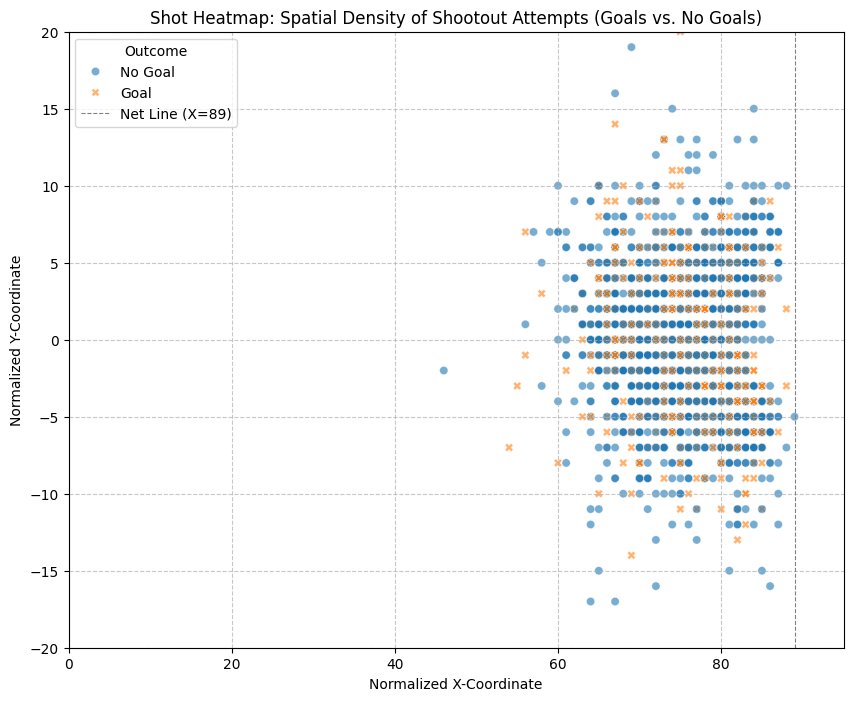

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_so, x='x', y='y', hue='is_goal', style='is_goal', alpha=0.6)
plt.title('Shot Heatmap: Spatial Density of Shootout Attempts (Goals vs. No Goals)')
plt.xlabel('Normalized X-Coordinate')
plt.ylabel('Normalized Y-Coordinate')
plt.axvline(x=89, color='grey', linestyle='--', linewidth=0.8, label='Net Line (X=89)') # Assuming net is at x=89
plt.xlim(0, 95) # Focus on the attacking zone
plt.ylim(-20, 20) # A reasonable y-range for shot locations
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Outcome')
plt.show()

Shot Type vs. Conversion Rate

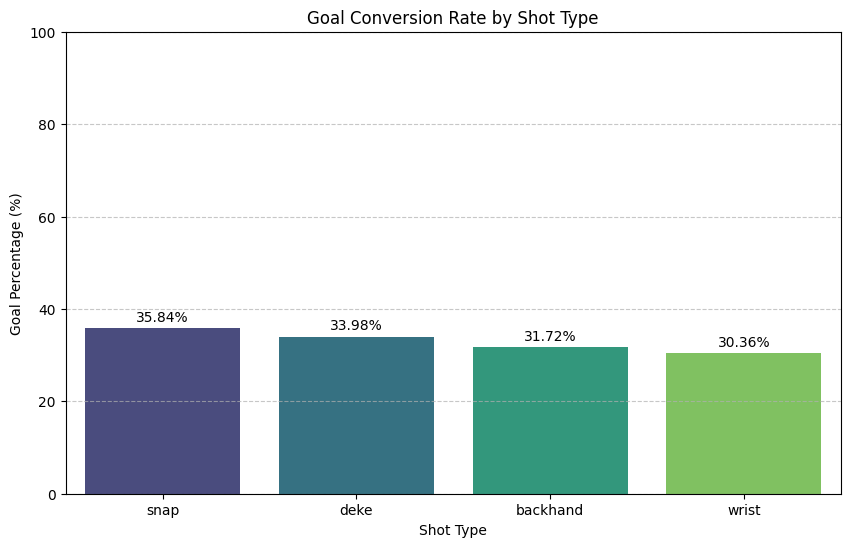

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the conversion rate for each shot type
shot_type_conversion = df_so.groupby('shot_type')['is_goal'].value_counts(normalize=True).unstack().fillna(0)
shot_type_conversion['Goal_Percentage'] = shot_type_conversion['Goal'] * 100

# Sort by Goal_Percentage for better visualization
shot_type_conversion = shot_type_conversion.sort_values(by='Goal_Percentage', ascending=False).reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=shot_type_conversion, x='shot_type', y='Goal_Percentage', hue='shot_type', palette='viridis', legend=False)

# Add percentage labels above each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='edge', padding=3)

plt.title('Goal Conversion Rate by Shot Type')
plt.xlabel('Shot Type')
plt.ylabel('Goal Percentage (%)')
plt.ylim(0, 100) # Ensure y-axis goes from 0 to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Handedness Matchup Matrix.
A heatmap showing the goal percentage percentage based on the combinations of player handedness (L/R) and golaie handedness (L/R). This will help identify any significant matchups.


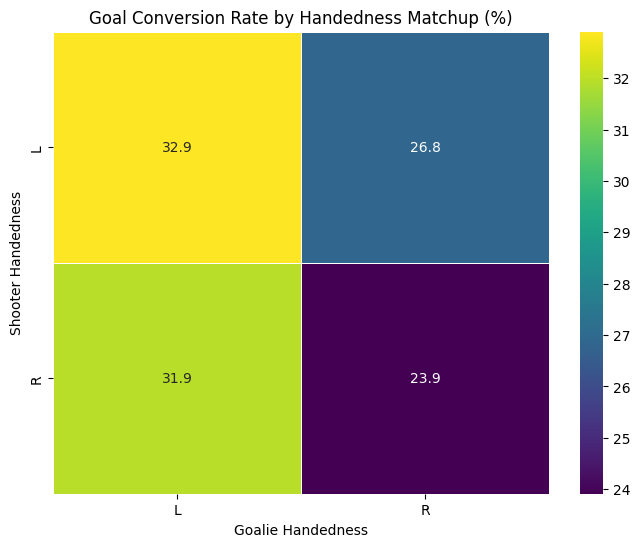

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert 'is_goal' to numerical (0/1) for calculation
df_so['is_goal_numeric'] = df_so['is_goal'].map({'No Goal': 0, 'Goal': 1})

# Calculate the mean is_goal for each unique combination
matchup_conversion = df_so.groupby(['shooter_handedness', 'goalie_handedness'])['is_goal_numeric'].mean()

# 2. Pivot the resulting table
matchup_matrix = matchup_conversion.unstack()

# 3. Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    matchup_matrix * 100, # Convert to percentage
    annot=True,
    fmt='.1f', # Display as percentage with one decimal place. The '%' is added implicitly by multiplying by 100 and stating it in the title.
    cmap='viridis',
    linewidths=.5
)

# 4. Add a title
plt.title('Goal Conversion Rate by Handedness Matchup (%)')
plt.xlabel('Goalie Handedness')
plt.ylabel('Shooter Handedness')

# 5. Display the plot
plt.show()

Distance vs. Goal Probability.
A line plot showing the probability of a goal as a function of distance from the net. This involves calculating distance from the normalized coordinates and binning it appropriately.


In [47]:
import numpy as np

# Assuming the net is at (89, 0) after normalization
net_x = 89
net_y = 0

df_so['distance_from_net'] = np.sqrt((df_so['x'] - net_x)**2 + (df_so['y'] - net_y)**2)

print("First 5 rows with 'distance_from_net':")
print(df_so[['x', 'y', 'distance_from_net']].head())

First 5 rows with 'distance_from_net':
    x  y  distance_from_net
0  84 -7           8.602325
1  73 -2          16.124515
2  82 -6           9.219544
3  67  1          22.022716
4  70 -2          19.104973


In [48]:
max_distance = df_so['distance_from_net'].max()
bins = np.arange(0, max_distance + 5, 5) # Create bins every 5 units
labels = [f'{i}-{i+5}' for i in bins[:-1]]

df_so['distance_bin'] = pd.cut(df_so['distance_from_net'], bins=bins, labels=labels, right=False)

print("First 5 rows with 'distance_bin':")
print(df_so[['distance_from_net', 'distance_bin']].head())
print("\nDistribution of 'distance_bin':")
print(df_so['distance_bin'].value_counts().sort_index())

First 5 rows with 'distance_bin':
   distance_from_net distance_bin
0           8.602325     5.0-10.0
1          16.124515    15.0-20.0
2           9.219544     5.0-10.0
3          22.022716    20.0-25.0
4          19.104973    15.0-20.0

Distribution of 'distance_bin':
distance_bin
0.0-5.0        10
5.0-10.0      712
10.0-15.0    1136
15.0-20.0     713
20.0-25.0     382
25.0-30.0      81
30.0-35.0      12
35.0-40.0       1
40.0-45.0       1
Name: count, dtype: int64


In [49]:
distance_conversion_rate = df_so.groupby('distance_bin')['is_goal_numeric'].mean().reset_index()
distance_conversion_rate.rename(columns={'is_goal_numeric': 'Goal Probability'}, inplace=True)

print("Goal conversion rate by distance bin:")
print(distance_conversion_rate)

Goal conversion rate by distance bin:
  distance_bin  Goal Probability
0      0.0-5.0          0.300000
1     5.0-10.0          0.352528
2    10.0-15.0          0.331866
3    15.0-20.0          0.307153
4    20.0-25.0          0.285340
5    25.0-30.0          0.209877
6    30.0-35.0          0.416667
7    35.0-40.0          1.000000
8    40.0-45.0          0.000000


/tmp/ipython-input-202/3074050404.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_conversion_rate = df_so.groupby('distance_bin')['is_goal_numeric'].mean().reset_index()


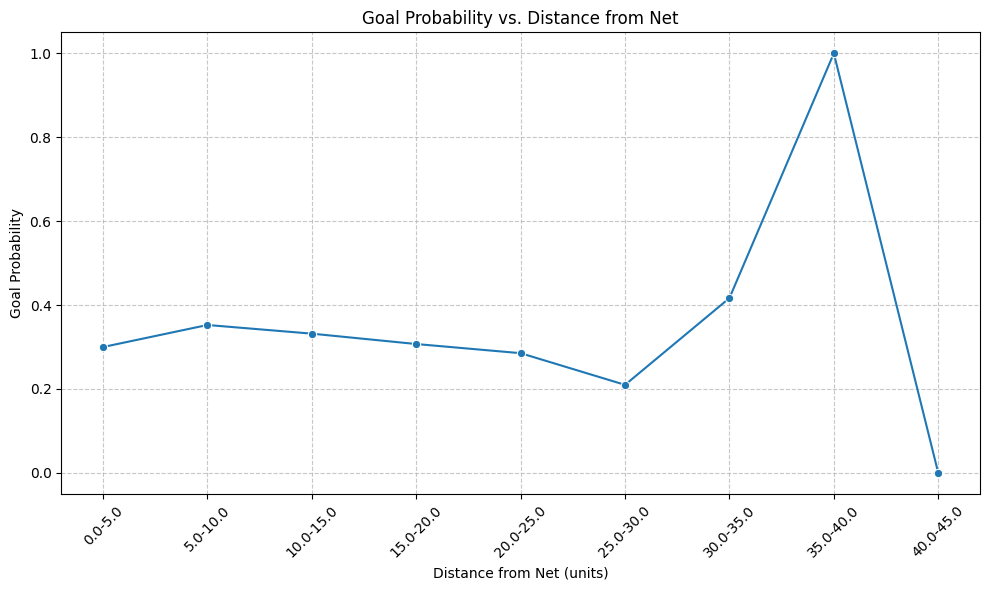

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=distance_conversion_rate, x='distance_bin', y='Goal Probability', marker='o')
plt.title('Goal Probability vs. Distance from Net')
plt.xlabel('Distance from Net (units)')
plt.ylabel('Goal Probability')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability if many bins
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##4. Methodology